## Scalability experiments
This notebook contains some code that can be used for performing the scalability experiment showed on section 3.2.2 in which the time needed for finding the zero shortest path nodes is analysed

In [4]:
import sys
sys.path.append("./functions")

from utils import *
from model_bet import *
from layer import *

### The corresponding ER graphs are created for the experiment

In [ ]:
'''

This code generates different ER graphs for scalability test

'''


# Generating some Erdos-Renyi graphs for scalability tests

#nodes = [100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]
nodes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
edges = [2,4,6]

for n in nodes:
    for e in edges:
        list_bet_data = list()
        p = e/n

        print(f"Generating ER graph: {n} nodes, {e} avg edges")
        g_nx = nx.generators.random_graphs.fast_gnp_random_graph(n,p = p,directed = True)
        if nx.number_of_isolates(g_nx)>0:
            g_nx.remove_nodes_from(list(nx.isolates(g_nx)))
        g_nx = nx.convert_node_labels_to_integers(g_nx)
        g_nkit = nx2nkit(g_nx)
        bet_dict = {j:0 for j in g_nkit.iterNodes()} # We set the betweenness data to 0 sinnce we don't need it for this experiment
        deg_dict = {j:0 for j in g_nkit.iterNodes()} # the same
        list_bet_data.append([g_nx,bet_dict,deg_dict])

        fname_bet = f"./graphs/ER_1_graph_{n}_nodes_{e}_edges.pickle"

        with open(fname_bet,"wb") as fopen:
            pickle.dump(list_bet_data,fopen)

print("Finished")

###  The related datasets are created

In [12]:
param = {
    "nodes" : [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000],#[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000],
    "edges" : [2,4,6],
    "num_train" : 0,
    "num_test" : 1,
    "num_copies": [1],
    "split_seeds": [10],
}


for size in param["nodes"]:
    for edges in param["edges"]:
        for num_copies in param["num_copies"]:
            for splitseed in param["split_seeds"]:
        
                with open(f"./graphs/ER_1_graph_{size}_nodes_{edges}_edges.pickle","rb") as fopen:
                    list_data = pickle.load(fopen)

                num_graph = len(list_data)
                assert param["num_train"]+param["num_test"] == num_graph,"Required split size doesn't match number of graphs in pickle file."

                #For test split
                if param["num_test"] > 0:
                    random.seed(splitseed)
                    list_graph, list_n_sequence, list_node_num, cent_mat, deg_mat = create_dataset(list_data[param["num_train"]:param["num_train"]+param["num_test"]],num_copies = 1,adj_size=size)

                    with open(f"./data_splits/ER_1_graph_{size}_nodes_{edges}_edges.pickle","wb") as fopen:
                        pickle.dump([list_graph,list_n_sequence,list_node_num,cent_mat, deg_mat],fopen)


### The time needed for the process of finding the zero shortest path nodes is analysed for the different ER  graphs considered

In [ ]:
nodes = [100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]
nodes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
edges = [2,4,6]

results = []

for n in nodes:
    for e in edges:
        print(f"Processing graph {n} nodes and {e} edges.")
        file = f'ER_1_graph_{n}_nodes_{e}_edges.pickle'
        #Load data
        with open(f"./data_splits/{file}","rb") as fopen:
            list_graph_test,list_n_seq_test,list_num_node_test,bc_mat_test,deg_mat_test = pickle.load(fopen)

        model_size = bc_mat_test.shape[0]

        #Get adjacency matrices from graphs
        print(f"Graphs to adjacency conversion.")
        starting = time.time()
        list_adj_test,list_adj_t_test = graph_to_adj_bet(list_graph_test,list_n_seq_test,list_num_node_test,model_size)
        end = time.time()

        results.append({"n": n, "e": e, "t": round(end-starting,4)})
with open(f"./outputs/scalability_results.pickle","wb") as fopen:
            pickle.dump(results,fopen)

### The results obtained are  plotted

[[100000, 3.8781], [200000, 8.3156], [300000, 13.3347], [400000, 17.9544], [500000, 23.1906], [600000, 27.1137], [700000, 33.5054], [800000, 35.5424], [900000, 42.5628], [1000000, 49.265]]
[[100000, 6.9503], [200000, 14.1868], [300000, 22.7505], [400000, 31.6379], [500000, 37.9235], [600000, 43.7345], [700000, 55.6405], [800000, 61.3296], [900000, 69.1965], [1000000, 82.1859]]
[[100000, 10.5527], [200000, 20.708], [300000, 31.017], [400000, 42.361], [500000, 53.0813], [600000, 66.2967], [700000, 79.7196], [800000, 90.3796], [900000, 112.1918], [1000000, 119.1985]]


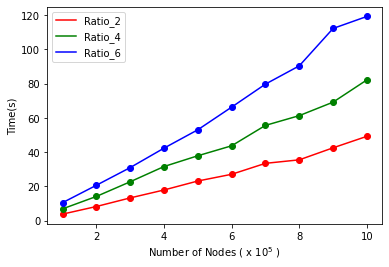

In [5]:
import matplotlib.pyplot as plt

with open(f"./outputs/old/auxresults.pickle","rb") as fopen:
    results = pickle.load(fopen)

line_2 = []
line_4 = []
line_6 = []
xs = []

for j in results:
    if j["e"] == 2:
        line_2.append([j['n'],j['t']])
    elif j["e"] == 4:
        line_4.append([j['n'],j['t']])
    else:
        line_6.append([j['n'],j['t']])

print(line_2)
print(line_4)
print(line_6)


xs = [j[0]/100000 for j in line_2]
ys = [j[1] for j in line_2]
plt.plot(xs,ys,color='r',label='Ratio_2')
plt.scatter(xs,ys,color='r')

xs = [j[0]/100000 for j in line_4]
ys = [j[1] for j in line_4]
plt.plot(xs,ys,color='g',label='Ratio_4')
plt.scatter(xs,ys,color='g')

xs = [j[0]/100000 for j in line_6]
ys = [j[1] for j in line_6]
plt.plot(xs,ys,color='b',label='Ratio_6')
plt.scatter(xs,ys,color='b')

plt.legend()
plt.ticklabel_format(axis='x',scilimits=(0,10))
plt.xlabel("Number of Nodes ( x 10$^5$ )")
plt.ylabel("Time(s)")
#plt.savefig("plots/exp-3-scalability.png",dpi=150)
plt.show()